In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
%matplotlib inline

In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # set True to be faster
    print(f'Setting all seeds to be {seed} to reproduce...')
seed_everything(42)

Setting all seeds to be 42 to reproduce...


# Showing chars

In [ ]:
db = h5py.File('/content/drive/MyDrive/CV Project/SynthText_train.h5', 'r')
im_names = list(db['data'].keys())
shape_list, words_list = [], []
cropped_images = []
targets = []
char_list = []
for img_idx, im in enumerate(im_names):
    img = db['data'][im][:]
    font = db['data'][im].attrs['font']
    txt = db['data'][im].attrs['txt']
    charBB = db['data'][im].attrs['charBB']
    wordBB = db['data'][im].attrs['wordBB']
    for i in range(charBB.shape[-1]):
        x_coor = np.int0(charBB[0,:,i])
        y_coor = np.int0(charBB[1,:,i])
        box = [min(x_coor), min(y_coor),
                max(x_coor), max(y_coor)]
        box = [t if t>=0 else 0 for t in box]
        warped = img[box[1]:box[-1], box[0]:box[2]]
        cropped_images.append(warped)
        targets.append(str(font[i]))
        shape_list.append((warped.shape[0], warped.shape[1]))
    words_list += list(txt)
    for word in txt:
        for c in word.astype(str):
            char_list.append(c)

Text(0.5, 1.0, 'Char Height')

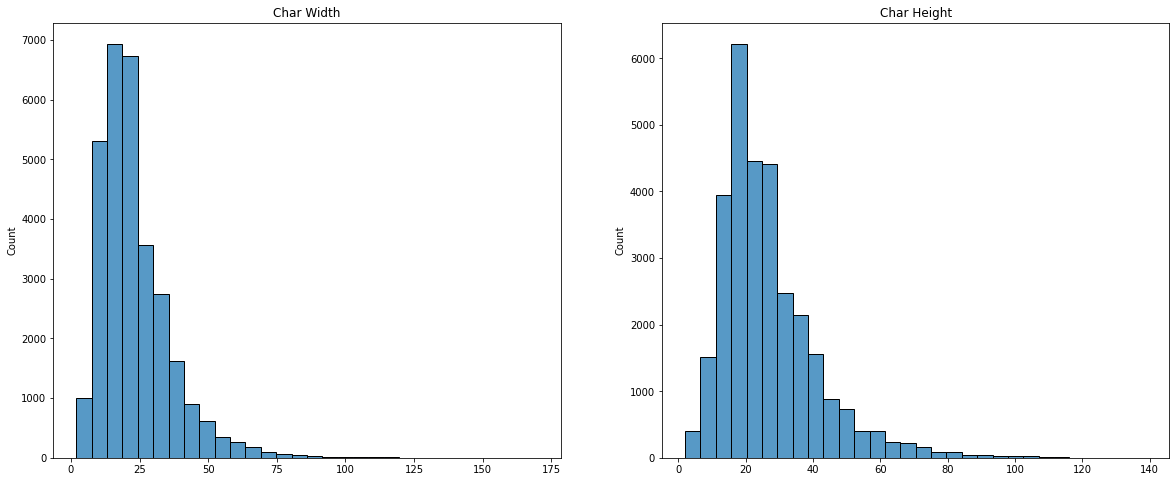

In [ ]:
width_list = []
height_list = []
for size in shape_list:
    width_list.append(size[1])
    height_list.append(size[0])
fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
sns.histplot(width_list, bins=30, ax=ax[0])
ax[0].set_title('Char Width')
sns.histplot(height_list, bins=30, ax=ax[1])
ax[1].set_title('Char Height')

Text(0.5, 1.0, 'Char Count')

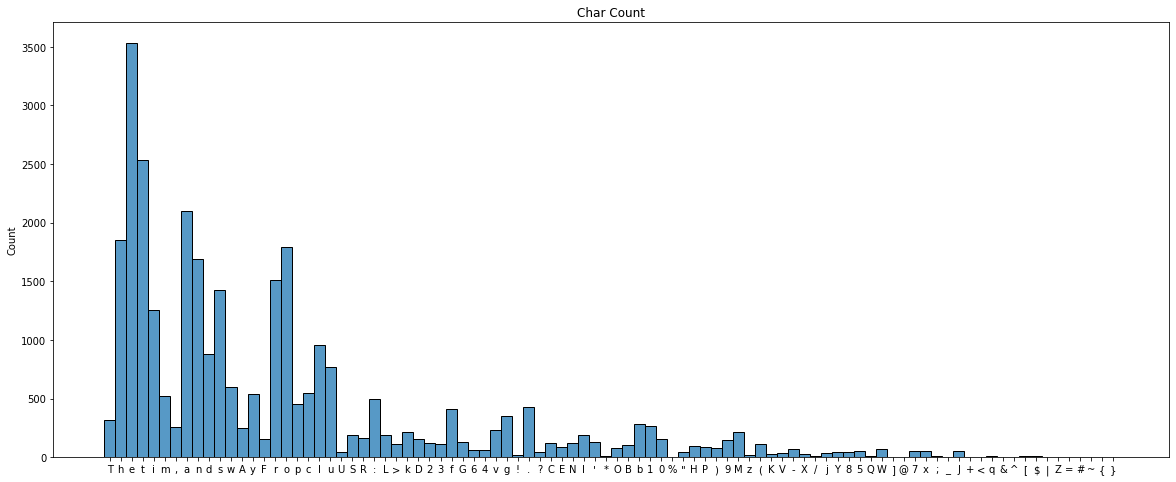

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))
sns.histplot(char_list, ax=ax)
ax.set_title('Char Count')

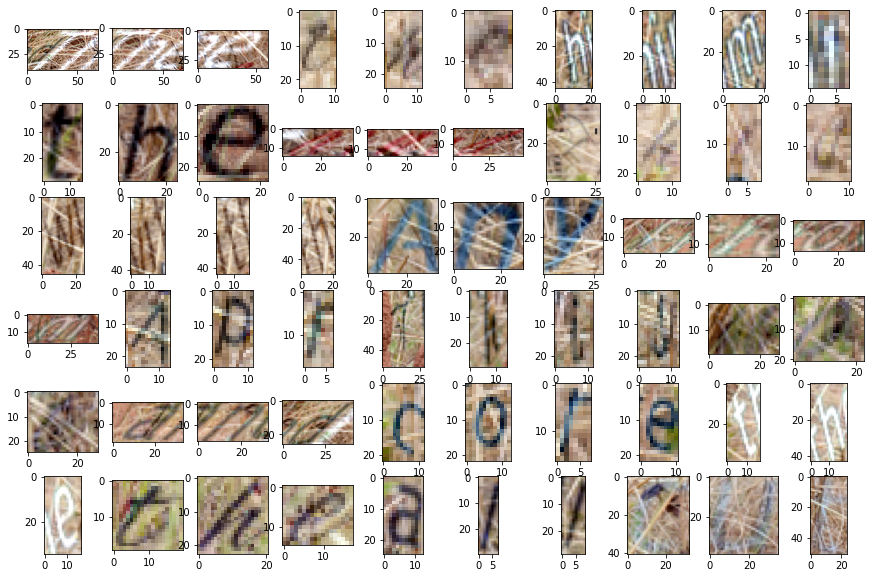

In [ ]:
fig, ax = plt.subplots(nrows = 6, ncols = 10, figsize=(15,10))
i = 0
for row in ax:
    for col in row:
        col.imshow(cropped_images[i])
        i += 1

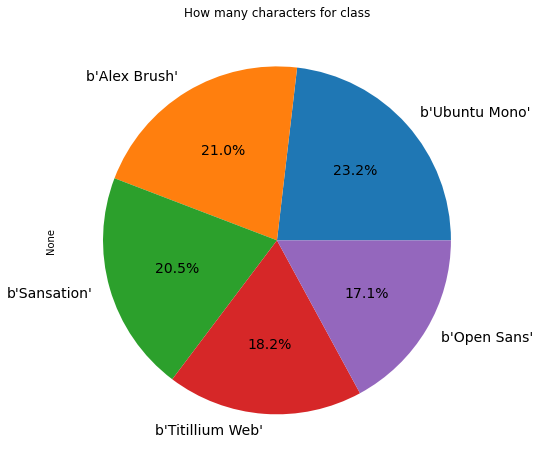

In [ ]:
plt.figure(figsize=(20,15))
pd.Series(targets).value_counts().plot(kind = 'pie',
                                                title = 'How many characters for class',
                                                autopct = '%1.1f%%', 
                                                shadow = False, 
                                                legend = False, 
                                                fontsize = 14, 
                                                figsize = (18,8),
                                      )

# Getting the wrapped characters using homography so the model can focus on the charcters instead of the background.
### In some cases the character will be flipped in the other direction and cause a character to be flipped by 90 degrees to the other side. It happens due to bad labeling of the characters. in order to tackle that i decided to define a variable called "epsilon" that wont make the character flip if the margin between bounding box points is small. if it really is the case we can assume that characters are centered without much background, hence they dont need to be wrapped and we also dont risk flipping them in the wrong direction.

In [ ]:
db = h5py.File('SynthText_train.h5', 'r')
epsilon = 6
val_size = 0.2
im_names = list(db['data'].keys())
shape_list, train_words_list, val_words_list = [], [], []
train_cropped_images, val_cropped_images = [], []
train_targets, val_targets = [], []
for img_idx, im in enumerate(im_names):
    img = db['data'][im][:]
    font = db['data'][im].attrs['font']
    txt = db['data'][im].attrs['txt']
    charBB = db['data'][im].attrs['charBB']
    wordBB = db['data'][im].attrs['wordBB']
    for i in range(charBB.shape[-1]):  # For each character bounding box
        x_coor = np.int0(charBB[0,:,i])
        y_coor = np.int0(charBB[1,:,i])
        rect = cv2.minAreaRect(np.c_[x_coor,y_coor])
        
        x1,x2 = x_coor[0], x_coor[-1]
        if x2 > x1 + epsilon:
            height = int(rect[1][0])
            width = int(rect[1][1])
            box = cv2.boxPoints(rect)
            dst_points = np.array([
                                [0, 0],
                                [width-1, 0],
                                [width-1, height-1],[0, height-1]], dtype="float32")
            
            M = cv2.getPerspectiveTransform(box, dst_points)
            warped = cv2.warpPerspective(img, M, (width, height))

        elif x2 + epsilon < x1:
            width = int(rect[1][0])
            height = int(rect[1][1])
            box = cv2.boxPoints(rect)
            dst_points = np.array([[0, height-1],
                                [0, 0],
                                [width-1, 0],
                                [width-1, height-1]], dtype="float32")
        
            M = cv2.getPerspectiveTransform(box, dst_points)
            warped = cv2.warpPerspective(img, M, (width, height))
            
        else:
            box = [min(x_coor), min(y_coor),
                   max(x_coor), max(y_coor)]
            box = [t if t>=0 else 0 for t in box]
            warped = img[box[1]:box[-1], box[0]:box[2]]
        
        if img_idx > len(im_names) * val_size:
            train_cropped_images.append(warped)
            train_targets.append(str(font[i]))
        else:
            val_cropped_images.append(warped)
            val_targets.append(str(font[i]))
        
        
        shape_list.append((warped.shape[0], warped.shape[1]))
    
    if img_idx > len(im_names) * val_size:
        train_words_list += list(txt)
    else:
        val_words_list += list(txt)

In [ ]:
print(len(train_targets))
print(len(val_targets))

24713
5807


In [ ]:
width_list = []
height_list = []
for size in shape_list:
    width_list.append(size[1])
    height_list.append(size[0])

# First lets explore the size of our images.

Text(0.5, 1.0, 'Words Height')

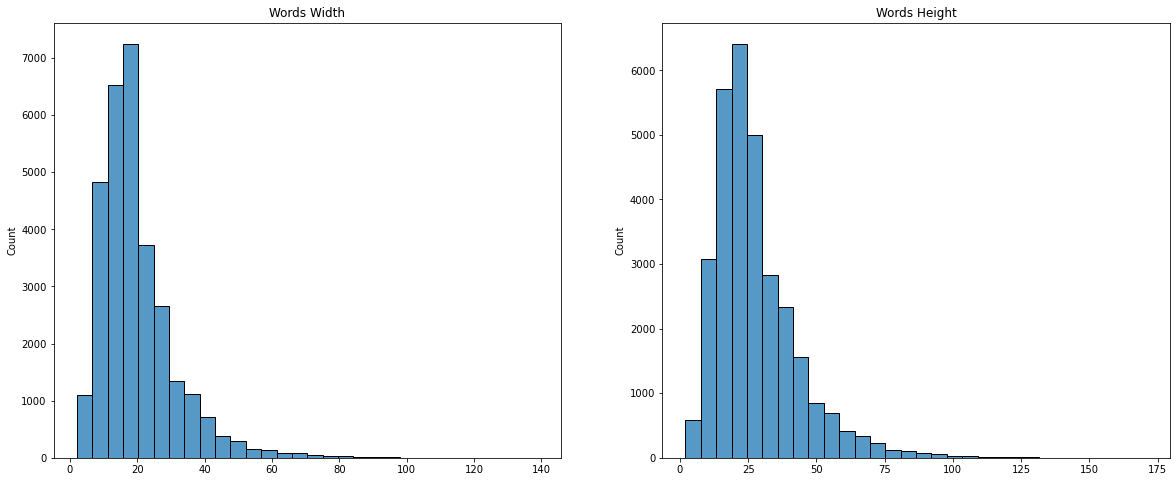

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
sns.histplot(width_list, bins=30, ax=ax[0])
ax[0].set_title('Words Width')
sns.histplot(height_list, bins=30, ax=ax[1])
ax[1].set_title('Words Height')

# Check if theres an imbalance between classes

<AxesSubplot:title={'center':'How many words for class'}, ylabel='None'>

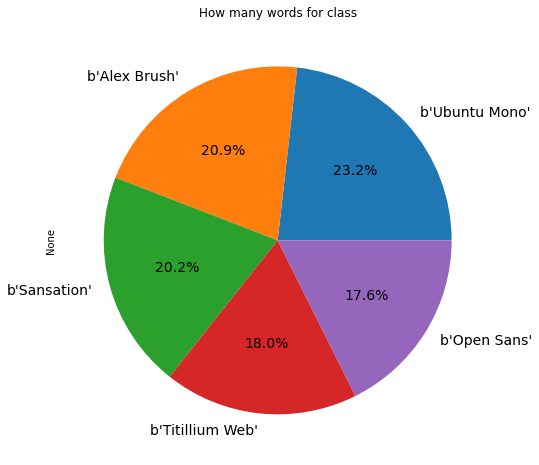

In [ ]:
plt.figure(figsize=(20,15))
pd.Series(train_targets).value_counts().plot(kind = 'pie',
                                                title = 'How many words for class',
                                                autopct = '%1.1f%%', 
                                                shadow = False, 
                                                legend = False, 
                                                fontsize = 14, 
                                                figsize = (18,8),
                                      )

# Lets have a look at an example of an image

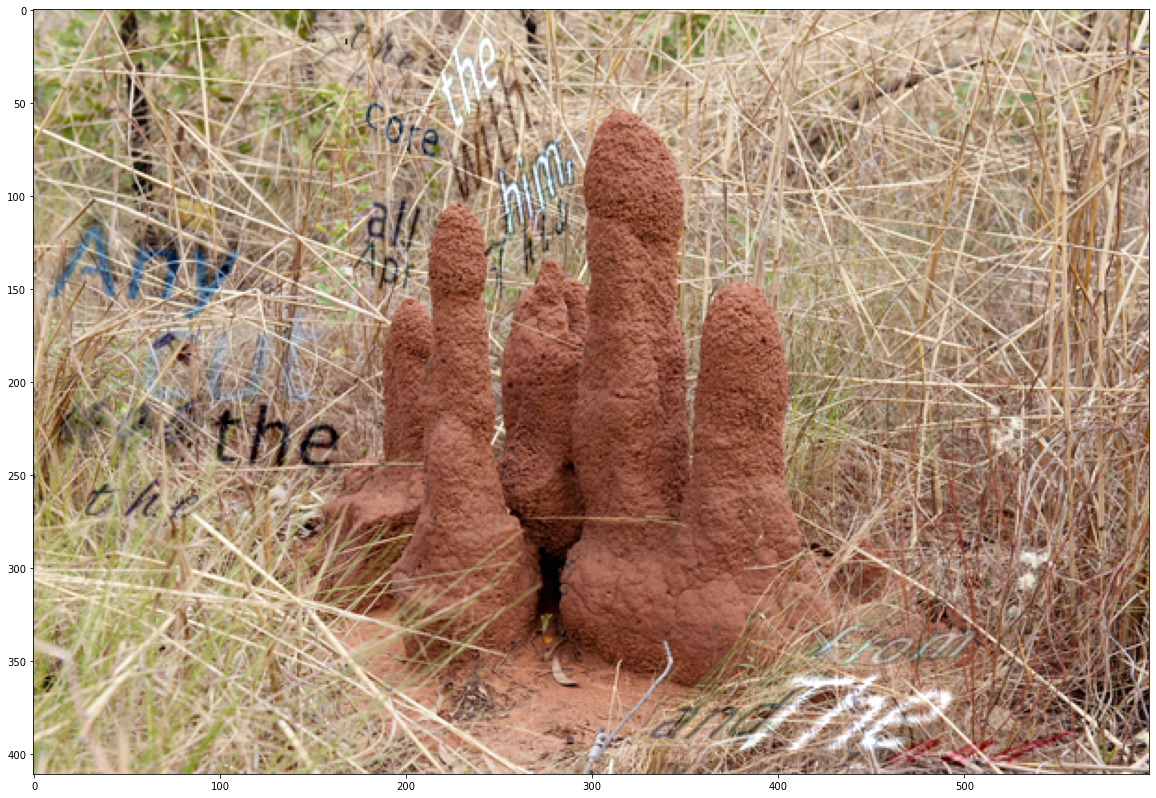

In [ ]:
plt.figure(figsize=(20,15))
plt.imshow(db['data'][im_names[0]][:])

# Chars after being wrapped

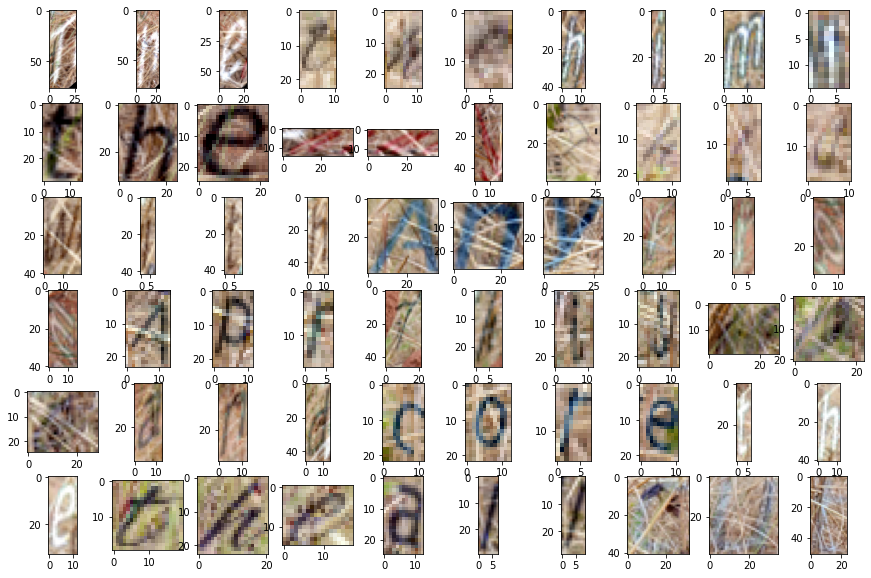

In [ ]:
fig, ax = plt.subplots(nrows = 6, ncols = 10, figsize=(15,10))
i = 0
for row in ax:
    for col in row:
        col.imshow(val_cropped_images[i])
        i += 1

In [ ]:
class FontImages(Dataset):
    def __init__(self, images, mode, words=None, targets=None, transform=None):
        self.transform = transform
        self.targets = targets
        self.images = images
        self.mode = mode
        self.words = words
        if self.words:
            self.chars = []
            for i, word in enumerate(self.words):
                for _ in word:
                    self.chars.append(i)

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, i):
        if self.mode == 'train':
            image = self.images[i]
            target = self.targets[i]
            if self.transform:
                image = self.transform(image=image)['image']
            return image.float(), torch.tensor(target)
        
        if self.mode == 'val':
            image = self.images[i]
            target = self.targets[i]
            if self.transform:
                image = self.transform(image=image)['image']
            return i, image.float(), torch.tensor(target)
            
        else:
            image = self.images[i]
            if self.transform:
                image = self.transform(image=image)['image']
            return i, image.float()

In [ ]:
# class Poly1CrossEntropyLoss(nn.Module):
#     def __init__(self,
#                  num_classes: int,
#                  epsilon: float = 1.0,
#                  reduction: str = "none",
#                  weight: torch.Tensor = None):
#         """
#         Create instance of Poly1CrossEntropyLoss
#         :param num_classes:
#         :param epsilon:
#         :param reduction: one of none|sum|mean, apply reduction to final loss tensor
#         :param weight: manual rescaling weight for each class, passed to Cross-Entropy loss
#         """
#         super(Poly1CrossEntropyLoss, self).__init__()
#         self.num_classes = num_classes
#         self.epsilon = epsilon
#         self.reduction = reduction
#         self.weight = weight
#         return

#     def forward(self, logits, labels):
#         """
#         Forward pass
#         :param logits: tensor of shape [N, num_classes]
#         :param labels: tensor of shape [N]
#         :return: poly cross-entropy loss
#         """
#         labels_onehot = F.one_hot(labels, num_classes=self.num_classes).to(device=logits.device,
#                                                                            dtype=logits.dtype)
#         pt = torch.sum(labels_onehot * F.softmax(logits, dim=-1), dim=-1)
#         CE = F.cross_entropy(input=logits,
#                              target=labels,
#                              reduction='none',
#                              weight=self.weight)
#         poly1 = CE + self.epsilon * (1 - pt)
#         if self.reduction == "mean":
#             poly1 = poly1.mean()
#         elif self.reduction == "sum":
#             poly1 = poly1.sum()
#         return poly1

In [ ]:
class CircleLoss(nn.Module):
    def __init__(self, in_features, out_features, s=256, m=0.25):
        super(CircleLoss, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad=True)
        self._s = s
        self._m = m
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    def __call__(self, bn_feat, targets=None, train=True):
        sim_mat = F.linear(F.normalize(bn_feat), F.normalize(self.weight))
        if not train:
            return self._s * sim_mat
        alpha_p = F.relu(-sim_mat.detach() + 1 + self._m)
        alpha_n = F.relu(sim_mat.detach() + self._m)
        delta_p = 1 - self._m
        delta_n = self._m

        s_p = self._s * alpha_p * (sim_mat - delta_p)
        s_n = self._s * alpha_n * (sim_mat - delta_n)

        one_hot = torch.zeros(sim_mat.size(), device=targets.device)
        one_hot.scatter_(1, targets.view(-1, 1).long(), 1)

        pred_class_logits = one_hot * s_p + (1.0 - one_hot) * s_n

        return pred_class_logits

In [ ]:
# class ArcMarginProduct(nn.Module):
#     def __init__(self, in_features, out_features, s=64, m=0.5, easy_margin=False):
#         super(ArcMarginProduct, self).__init__()
#         self.in_features = in_features
#         self.out_features = out_features
#         self.s = s
#         self.m = m
#         self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
#         nn.init.xavier_uniform_(self.weight)

#         self.easy_margin = easy_margin
#         self.cos_m = math.cos(m)
#         self.sin_m = math.sin(m)
#         self.th = math.cos(math.pi - m)
#         self.mm = math.sin(math.pi - m) * m

#     def forward(self, input, label=False, train=True):
#         # --------------------------- cos(theta) & phi(theta) ---------------------------
#         cosine = F.linear(F.normalize(input), F.normalize(self.weight))
#         sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
#         phi = cosine * self.cos_m - sine * self.sin_m
#         if self.easy_margin:
#             phi = torch.where(cosine > 0, phi, cosine)
#         else:
#             phi = torch.where(cosine > self.th, phi, cosine - self.mm)
#         if train:
#             one_hot = torch.zeros(cosine.size(), device='cuda')
#             one_hot.scatter_(1, label.cuda().view(-1, 1).long(), 1)
#             output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
#         else:
#             output = cosine
#         output *= self.s

#         return output

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()        
        self.model = torchvision.models.efficientnet_b0(torchvision.models.EfficientNet_B0_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(in_features=1280, out_features=512)

    def forward(self, x):
        features = self.model(x)
        return features

In [ ]:
# def remove_noise(images,targets):
#     to_keep = []
#     for i in range(len(images)):
#         s = images[i].shape[:-1]
#         if s[0] * s[1] > 100:
#             to_keep.append(i)
#     to_keep = np.array(to_keep)
#     return images[to_keep], targets[to_keep]

In [ ]:
encoder = preprocessing.LabelEncoder()
train_targets = encoder.fit_transform(train_targets)
val_targets = encoder.transform(val_targets)

In [ ]:
print(len(train_targets))
print(len(val_targets))

24713
5807


In [ ]:
init_lr = 3e-5
weight_decay = 2e-5
n_epochs = 60
batch_size = 10
num_classes = 5
device = torch.device('cuda')

train_transform = A.Compose(
    [
        A.augmentations.geometric.resize.Resize(224,224),
        A.OneOf([
              A.Affine(shear=[-10,10], rotate=[-10,10]),
              A.RandomBrightnessContrast(),
              A.GaussianBlur(),
              A.MotionBlur(),
          ], p=1),
        A.augmentations.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),  # ImageNet normalization values
        ToTensorV2()
    ]
)



val_transform = A.Compose(
    [
        A.augmentations.geometric.resize.Resize(224,224),
        A.augmentations.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),  # ImageNet normalization values
        ToTensorV2()
    ]
)


model = Model()
model = model.to(device)


# loss_func = ArcMarginProduct(512, num_classes ,s=2, m=0.2).to(device)
loss_func = CircleLoss(in_features=512, out_features=5, s=4, m=0.4).to(device)
loss_optimizer = optim.Adam([loss_func.weight], lr = init_lr, weight_decay=weight_decay)
loss_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(loss_optimizer, n_epochs)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = init_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,n_epochs)
# Train dataset
train_dataset = FontImages(images=train_cropped_images, mode='train', targets=train_targets, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Validation dataset
val_dataset = FontImages(images=val_cropped_images, mode='val', words=val_words_list, targets=val_targets, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
def train_func(model, loss_func, train_loader):
    torch.cuda.empty_cache()
    model = model.train()
    loss_func = loss_func.train()
    running_loss = 0.0
    running_corrects = 0
    for images, targets in train_loader:
        targets = targets.type(torch.LongTensor)
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        logits = loss_func(logits, targets)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        _, preds = torch.max(logits, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == targets)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        
    train_loss = running_loss / len(train_dataset.targets)
    train_acc = running_corrects.double() / len(train_dataset.targets)
    print(f'Training Accuracy = {train_acc}, Training Loss = {train_loss}')
    
    return train_loss, train_acc

# The validation function will calculate the per character accuracy as well as the voting accuracy

In [ ]:
def val_func(model, loss_func, val_loader):
    torch.cuda.empty_cache()
    model = model.eval()
    loss_func = loss_func.eval()
    running_val_loss = 0.0
    running_corrects = 0
    predictions = [[] for _ in range(len(val_dataset.words))]
    with torch.no_grad():
        for i, images, targets in val_loader:
            targets = targets.type(torch.LongTensor)
            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            logits = loss_func(logits, train=False)
            loss = criterion(logits, targets)
            running_val_loss += loss.item() * images.size(0)
            batch_preds_values, batch_preds = torch.max(logits, 1)
            running_corrects += torch.sum(batch_preds == targets)
            # Saving predictions and their confidence
            for j, pred, val in zip(i, batch_preds, batch_preds_values):
                predictions[val_dataset.chars[j]].append([int(pred), float(val)])
        
    majority_vote_pred = []
    for word_prediction in predictions:
        d = {}
        for pred, val in word_prediction:
            if pred in d:
                d[pred] += val
            else:
                d[pred] = val
        if d:
            # max prediction will be the key with maximum confidence
            max_prediction = max(d, key=d.get)
            # predict the max prediction len(word) times
            majority_vote_pred += [max_prediction]*len(word_prediction)
    
    majority_vote_pred = np.array(majority_vote_pred)
    val_majority_acc = sum(majority_vote_pred == val_dataset.targets)/len(val_dataset.targets)
    val_acc = running_corrects.double() / len(val_dataset.targets)
    val_loss = running_val_loss / len(val_dataset.targets)
    print(f'Validation Accuracy = {val_acc}, Voting Validation Accuracy = {val_majority_acc}, Validation Loss = {val_loss}')
    return val_loss, val_acc, val_majority_acc

# Training our final model

In [ ]:
train_acc_list = []
val_acc_list = []
loss_list = []
val_loss_list = []
val_majority_acc_list = []
best_score = 0.0
for epoch in range(1, n_epochs + 1):
    print(f'epoch = {epoch}')
    loss, train_acc = train_func(model, loss_func, train_loader)
    val_loss, val_acc, val_majority_acc = val_func(model, loss_func, val_loader)
    scheduler.step()
    loss_scheduler.step()
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_majority_acc_list.append(val_majority_acc)
    if val_acc > best_score:
        best_score = val_acc
        torch.save(model.state_dict(), 'effnetb0_circle_char_without.pth')
        torch.save(loss_func.state_dict(), 'effnetb0_loss_circle_char_without.pth')

epoch = 1
Training Accuracy = 0.2679966009792417, Training Loss = 1.9084269058379737
Validation Accuracy = 0.665576028930601, Voting Validation Accuracy = 0.7155157568451869, Validation Loss = 0.8219157591351794
epoch = 2
Training Accuracy = 0.43640998664670416, Training Loss = 1.6613703670348507
Validation Accuracy = 0.7379025314275873, Voting Validation Accuracy = 0.8198725675908386, Validation Loss = 0.6771912302431191
epoch = 3
Training Accuracy = 0.5285881924493182, Training Loss = 1.5739137706466009
Validation Accuracy = 0.7633890132598588, Voting Validation Accuracy = 0.8377819872567591, Validation Loss = 0.608992061468519
epoch = 4
Training Accuracy = 0.5863310808076722, Training Loss = 1.5137216167390524
Validation Accuracy = 0.7719993111761666, Voting Validation Accuracy = 0.8513862579645256, Validation Loss = 0.584487632632933
epoch = 5
Training Accuracy = 0.6252174968639987, Training Loss = 1.4607905745482168
Validation Accuracy = 0.7880144653004993, Voting Validation Accur

Training Accuracy = 0.9604256868854449, Training Loss = 1.0031715341384768
Validation Accuracy = 0.8401928706733253, Voting Validation Accuracy = 0.918202169795075, Validation Loss = 0.5970952535320451
epoch = 41
Training Accuracy = 0.9587666410391292, Training Loss = 1.005694399567196
Validation Accuracy = 0.8360599276734975, Voting Validation Accuracy = 0.9097640778370931, Validation Loss = 0.5940076198056148
epoch = 42
Training Accuracy = 0.9611135839436734, Training Loss = 0.9983761041701668
Validation Accuracy = 0.8338212502152574, Voting Validation Accuracy = 0.9101084897537455, Validation Loss = 0.6044571476350025
epoch = 43
Training Accuracy = 0.9624489135272933, Training Loss = 0.9973520416016765
Validation Accuracy = 0.8327880144653005, Voting Validation Accuracy = 0.9133804029619425, Validation Loss = 0.5990110098307179
epoch = 44
Training Accuracy = 0.9626107716586413, Training Loss = 0.9973817673060594
Validation Accuracy = 0.8372653693817805, Voting Validation Accuracy = 

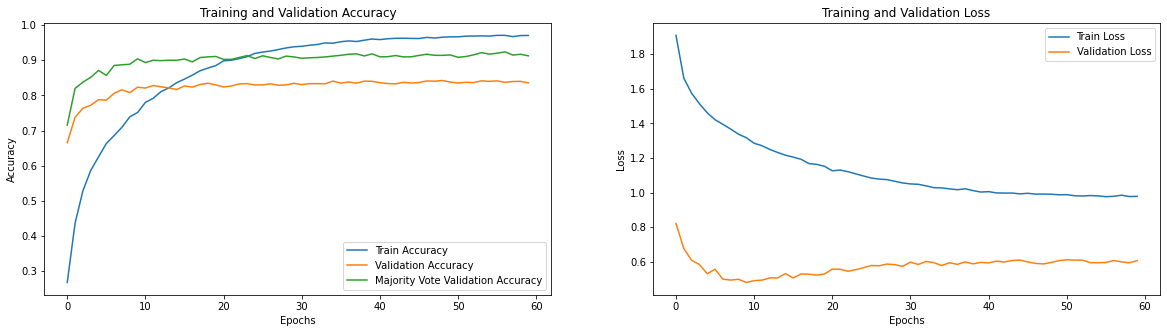

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1.plot(train_acc_list, label='Train Accuracy')
ax1.plot(val_acc_list, label='Validation Accuracy')
ax1.plot(val_majority_acc_list, label='Majority Vote Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(loss_list, label='Train Loss')
ax2.plot(val_loss_list, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Analyzing results

In [ ]:
torch.cuda.empty_cache()

# reduction='none' to get loss for each example
criterion = nn.CrossEntropyLoss(reduction='none')
examples_with_high_loss = []
with torch.no_grad():
    for i, (_, images, targets) in enumerate(val_loader):
        targets = targets.type(torch.LongTensor)
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        logits = loss_func(logits, train=False)
        loss = criterion(logits, targets)

        for j in range(images.shape[0]):
                curr_input = images[j].cpu()
                curr_label = targets[j].cpu()
                curr_loss = loss[j].item()
                examples_with_high_loss.append([curr_loss, curr_input, curr_label])

examples_with_high_loss = sorted(examples_with_high_loss, key=lambda x:x[0], reverse=True)

# Plotting 40 examples with highest loss

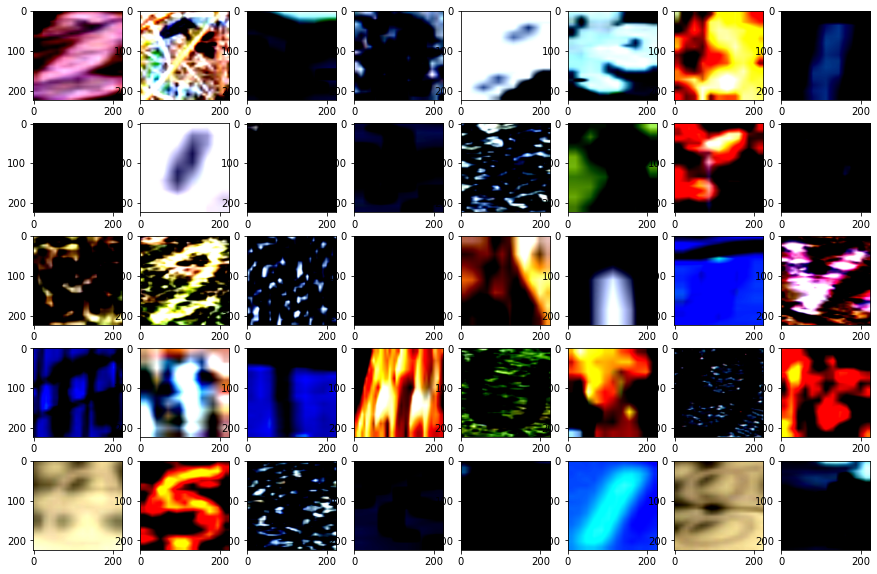

In [ ]:
fig, ax = plt.subplots(nrows = 5, ncols = 8, figsize=(15,10))
i = 0
for row in ax:
    for col in row:
        col.imshow(np.clip(examples_with_high_loss[i][1].permute(1, 2, 0), 0, 1), vmin=0, vmax=1)
        i += 1

### It seems like the model has the highest loss when trying to predict the "Titillium Web" font.

In [ ]:
d = {}
for _, __, target in examples_with_high_loss[:200]:
    if int(target) in d:
        d[int(target)] += 1
    else:
        d[int(target)] = 1

In [ ]:
{encoder.inverse_transform([k])[0]:v for k,v in d.items()}

{"b'Ubuntu Mono'": 14,
 "b'Titillium Web'": 79,
 "b'Open Sans'": 47,
 "b'Sansation'": 38,
 "b'Alex Brush'": 22}

# Testing